# NBA Project Explanation

This NBA data science project was inspired by wanting to optimize court spacing. The NBA today is heavily reliant on 3 point shooters with 5 man units often deploying 5 players who can shoot well. We believe that the next step may be to find where players take shots from in order to maximize each players shooting strengths and minimized their weaknesses. All data is downloaded from the NBA API. Player data downloaded from the NBA API is used to generate court area specific data of players shooting abilities. In specific, the 3NG (3 net gain) metric was used in order to assess 3 point shooting. 3NG is a comprehensive 3 point shooting metric that takes into account a players shooting percentages as well as the volume at which they shoot. We believed it was important to assess the fundamental problem if a 40% shooter who shoots 2 3s a game is better or worse than a 38% shooter who shoots 8 times a game. 3NG calculated values for players are used in order to generate an optimized court spacing for any given 5 man unit.

In [2]:
###### Importing important Modules #####

# Data and NBA API
import pandas as pd
import numpy as np

from scipy.stats import norm, gaussian_kde, percentileofscore

pd.options.display.max_columns = None
from nba_api.stats.static import players
from nba_api.stats.endpoints import shotchartdetail
from nba_api.stats.endpoints import playercareerstats

# For Shot Chart
import matplotlib.pyplot as plt
import seaborn as sns

from matplotlib import cm
from matplotlib.patches import Circle, Rectangle, Arc, ConnectionPatch
from matplotlib.patches import Polygon
from matplotlib.collections import PatchCollection
from matplotlib.colors import LinearSegmentedColormap, ListedColormap, BoundaryNorm
from matplotlib.path import Path
from matplotlib.patches import PathPatch

sns.set_style('white')
sns.set_color_codes()

# for 3NG optimization calcs
from itertools import permutations

/Users/teddyd/anaconda3/lib/python3.7/site-packages/pandas/compat/_optional.py:138: UserWarning: Pandas requires version '2.7.0' or newer of 'numexpr' (version '2.6.9' currently installed).
  warnings.warn(msg, UserWarning)
/Users/teddyd/anaconda3/lib/python3.7/site-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


## NBA API Data Extraction

The cell below was taken from another NBA project on github. It is used to extract player data from the NBA API, of which particularly useful for us is player tracking data of X,Y coordinates of shot locations.

In [3]:
##### Function to get 1 players information from NBA_API #####
# This was found on an NBA github project we need to cite

def get_player_shotchartdetail(player_name, season_id):
    """
    Parameters
    ----------
    player_name: name of the player with Capital
    season_id: ex. 2012-13
    """
    
    # player dictionary
    nba_players = players.get_players()
    player_dict = [player for player in nba_players if player['full_name'] == player_name][0]
    
    # career df
    career = playercareerstats.PlayerCareerStats(player_id=player_dict['id'])
    career_df = career.get_data_frames()[0]
    
    # team id during the season
    team_id = career_df[career_df['SEASON_ID'] == season_id]['TEAM_ID']
    
    # shotchardtdetail endpoint
    shotchartlist = shotchartdetail.ShotChartDetail(team_id=int(team_id), 
                                                   player_id=int(player_dict['id']), 
                                                   season_type_all_star='Regular Season', 
                                                   season_nullable=season_id,
                                                   context_measure_simple="FGA").get_data_frames()
    
    return shotchartlist[0], shotchartlist[1]

## Defining court locations from API X,Y coordinate data

The cell below is used to define a basketball court. The first half of the function was also taken from another NBA project on github. Extra areas were added in order to define specialized regions of the court that were needed to define the "area" from which a player took a shot. An example of such an area would be "Right Three". 

The bottom half of the cell is used in order to take in an X,Y coordinate and find its "area". This function is applied to the pandas dataframe generated by get_player_shot_detail in order to make a new column with shot_location of our specifically defined areas. 

In [4]:
####### Function to check if point is within region #####

from shapely.geometry import Point
from shapely.geometry.polygon import Polygon
import shapely.affinity

def find_court_location(x_loc, y_loc):
    """
    Takes in player shot location and outputs what region of the
    court they are on. The input must be a Point Object from
    shapely.geometry module.
    """
    
    player_shot_location = Point(x_loc,y_loc)
    
    ### Defining all possible areas of the court
    
    ## Rectangular Areas
    left_corner_three = Polygon([(-250, -47.5), (-250, 92.5), (-220, 92.5), (-220, -47.5)])
    right_corner_three = Polygon([(250, -47.5), (250, 92.5), (220, 92.5), (220, -47.5)])
    
    left_base_jump = Polygon([(-220, -47.5), (-220, 92.5), (-125, 92.5), (-125, -47.5)])
    right_base_jump = Polygon([(220, -47.5), (220, 92.5), (125, 92.5), (125, -47.5)])
    
    left_near_basket = Polygon([(-125, -47.5), (-125, 142.5), (0, 142.5), (0, -47.5)])
    right_near_basket = Polygon([(125, -47.5), (125, 142.5), (0, 142.5), (0, -47.5)])
    
    ## Left & Right Wing 2s
    circle = Point(0,0).buffer(1)
    three_circle = shapely.affinity.scale(circle, 237.5, 237.5)
    
    #making two polygons that contain the area that I want. 
    #If point is inside polygon area and circle then it is in long 2 area
    left_two_polygon = Polygon([(-250, 250), (-250, 92.5), (-125, 92.5), (-125, 250)])
    right_two_polygon = Polygon([(250, 250), (250, 92.5), (125, 92.5), (125, 250)])
     
    ## Left & Right Above FT 2s
    left_two_above_FT = Polygon([(-125, 250), (-125, 142.5), (0, 142.5), (0, 250)])
    right_two_above_FT = Polygon([(125, 250), (125, 142.5), (0, 142.5), (0, 250)])
    
    ## Above 3 point line
    big_circle = shapely.affinity.scale(circle, 287.5, 287.5)
    
    left_three_polygon = Polygon([(-250,300), (-250,0), (-125, 0), (-125, 300)])
    right_three_polygon = Polygon([(250,300), (250,0), (125, 0), (125, 300)])
    
    left_mid_three_polygon = Polygon([(-125,300), (-125,0), (0, 0), (0, 300)])
    right_mid_three_polygon = Polygon([(125,300), (125,0), (0, 0), (0, 300)])
    
    ## Dealing with Restricted Zone
    # Restricted zone below hoop (0,0)
    #left_restricted_line = Rectangle((-40, -47.5), 0, 47.5, linewidth=lw, color="red")
    restrict_below_hoop = Polygon([(-40,-47.5), (-40,0), (40, 0), (40, -47.5)])
    restrict_above_hoop = Polygon([(-40,0), (-40,40), (40, 40), (40, 0)])
    restrict_circle = shapely.affinity.scale(circle, 40, 40)

    
    ################### The below code is used to find a players given shot position given their X,Y coordinate #####
    if left_corner_three.contains(player_shot_location):
        return '3 pointer Left Corner'
    
    elif right_corner_three.contains(player_shot_location):
        return '3 pointer Right Corner'
        
    elif left_base_jump.contains(player_shot_location):
        return '2 pointer Left Baseline'
    
    elif right_base_jump.contains(player_shot_location):
        return '2 pointer Right Baseline'
        
    ##################### Restricted Zone ##################
    elif restrict_below_hoop.contains(player_shot_location):
        return 'Restricted Area'
        
    elif left_near_basket.contains(player_shot_location) & restrict_above_hoop.contains(player_shot_location) & restrict_circle.contains(player_shot_location):
        return 'Restricted Area'
        
    elif right_near_basket.contains(player_shot_location) & restrict_above_hoop.contains(player_shot_location) & restrict_circle.contains(player_shot_location):
        return 'Restricted Area'
        
    elif right_near_basket.contains(player_shot_location):
        return '2 pointer Left near basket'
        
    elif left_near_basket.contains(player_shot_location):
        return '2 pointer Right near basket'
    
    ######################################################
    elif three_circle.contains(player_shot_location) & left_two_polygon.contains(player_shot_location):
        return '2 pointer Left wing'
        
    elif three_circle.contains(player_shot_location) & right_two_polygon.contains(player_shot_location):
        return '2 pointer Right wing'
        
    elif three_circle.contains(player_shot_location) & left_two_above_FT.contains(player_shot_location):
        return '2 pointer Left above FT'
        
    elif three_circle.contains(player_shot_location) & right_two_above_FT.contains(player_shot_location):
        return '2 pointer Right above FT'
        
    elif big_circle.contains(player_shot_location) & left_three_polygon.contains(player_shot_location):
        return '3 pointer Left'
        
    elif big_circle.contains(player_shot_location) & right_three_polygon.contains(player_shot_location):
        return '3 pointer Right'
        
    elif big_circle.contains(player_shot_location) & left_mid_three_polygon.contains(player_shot_location):
        return '3 pointer Middle'
    
    elif big_circle.contains(player_shot_location) & right_mid_three_polygon.contains(player_shot_location):
        return '3 pointer Middle'       
    else:
        return 'Out of bounds'

## Extraction of NBA API data from multiple players

The below cell is an extension of get_players_shot_detail. It takes in a user defined dictionary of any # of players (although exactly 5 are needed in order to use the court spacing functions). Player dataframes are stored in a dictionary with keys as player names and values as their corresponding pandas dataframe that contain the extra shot location column.

In [5]:
##### Function to extract 5 players from the NBA API at once ####

def extract_players_API(dict_of_player_and_season):
    '''
    This function takes in a dictionary of players & years and outputs a dictionary of
    player name as the key & their pandas df as the value. This means that we can now
    build out the whole project directly from the API!!!
    '''
    
    dict_of_players_pd_df = {}
    
    for player in dict_of_player_and_season.keys():
        player_shot_chart_df, league_avg = get_player_shotchartdetail(player, dict_of_player_and_season[player])
        #dict_of_players_pd_df[player] = player_shot_chart_df
        
        new_shot_location = []

        for i in range(len(player_shot_chart_df)):
            new_shot_location.append(find_court_location(player_shot_chart_df.LOC_X[i], player_shot_chart_df.LOC_Y[i]))
    
        player_shot_chart_df['new_shot_location'] = new_shot_location
        
        dict_of_players_pd_df[player] = player_shot_chart_df
        
    return dict_of_players_pd_df

## Calculating 3NG

3NG (3 net gain) is a type of metric used to evaluate a players ability to shoot 3s. It is more comprehensive than any other 3 point shooting metrics as it takes volume of shooting into account. The formula for 3NG is 3NG = 3P * 1.94 - 3Mi * 1.06. 1.06 represents the average amount of points scored per possession in the NBA over the last 20 years, while 1.94 refers to the value added over 1.06 by making a 3 (3 - 1.06 = 1.94). 3P corresponds to made 3s and 3Mi corresponds to missed threes. 3NG is then divided by games played in order to get a 3NG per game metric. find_all_3NG calculates 3NG values for players at all 5 defined positions behind the 3 point line. A players total 3NG can be found by adding these if so desired.

In [6]:
#### Function for 3NG of each position on the court ###
def find_all_3NG(player_df):
    '''
    Takes in one players df & outputs their 3NG for each position.
    Function used in all_players_3NG to get 3NG values for all players.
    games_played variable is used to find the # of games a player played
    in a season in order to divide by that to calculate 3NG
    '''
    
    three_loc = ['3 pointer Left Corner', '3 pointer Middle', '3 pointer Right', 
                 '3 pointer Left',  '3 pointer Right Corner']
    
    shot_make_tracker = {}
    
    for shot_loc in three_loc:
        shot_data = player_df[player_df['new_shot_location'] == shot_loc]
        
        made_counter = 0
        missed_counter = 0
        
        for shot in shot_data['SHOT_MADE_FLAG']:
            if shot == 0:
                missed_counter += 1
            else:
                made_counter += 1
                
        #3NG = 3P * 1.94 - 3Mi * 1.06. 
        three_net_gain = round(made_counter*1.94 - missed_counter*1.06 , 2)
        games_played = len(player_df['GAME_ID'].unique())
        shot_make_tracker[shot_loc] = [[made_counter, missed_counter], round(three_net_gain/games_played, 2)]
        
    return shot_make_tracker

## Finding 3NG for all player data

The below function is an extension of find_all_3NG. It takes in the dictionary of 5 players made from extract_players_API & returns a dictionary with player names as the keys and their 3NG values from each position as the values.

In [7]:
#### Function to apply find_all_3NG for all players ###

def all_players_3NG(all_players_dict):
    '''
    Takes in the dictionary grabbed from the NBA API.
    Outputs a dictionary of players and their 3NG values from each location.
    '''
    
    player_3NG_dict = {}
    
    for player in all_players_dict.keys():
        player_3NG_dict[player] = find_all_3NG(all_players_dict[player])
    
    return player_3NG_dict

## Generating 3NG Numpy Array

The below function takes the dictionary created by all_players_3NG and returns a numpy arrary of 3NG values. This is needed in order to run optimized_player_location.

In [8]:
#### Function to create a numpy array of the output of all_players_3NG ###

def create_np_array_of_3NG(dict_of_3NG):
    '''
    Takes in a dictionary of 3NG values for players from each 5 positions behind the 3
    point line.
    Outputs a num py array which is necessary for the optimized_player_location function
    to work.
    '''
    index_1 = []
    index_2 = []
    index_3 = []
    index_4 = []
    index_5 = []

    for player in dict_of_3NG.keys():
        for shot_loc in dict_of_3NG[player]:
            if shot_loc == '3 pointer Left Corner':
                index_1.append(dict_of_3NG[player][shot_loc][1])
            if shot_loc == '3 pointer Middle':
                index_2.append(dict_of_3NG[player][shot_loc][1])
            if shot_loc == '3 pointer Right':
                index_3.append(dict_of_3NG[player][shot_loc][1])
            if shot_loc == '3 pointer Left':
                index_4.append(dict_of_3NG[player][shot_loc][1])
            if shot_loc == '3 pointer Right Corner':
                index_5.append(dict_of_3NG[player][shot_loc][1])
                
    return np.array([index_1, index_2, index_3, index_4, index_5])

## Finding Optimized Court Spacing for any 5 man unit

The cell below optimizes player locations based on their 3NG values at all 5 positions. This is the fundamental function for our project. It outputs a dictionary with keys of player names and values of the area that the player should stand in. Each player has a unique area. The function takes in a 5 x 5 numpy array and outputs the maximum possible 3NG sum that can be made, with constraints that 3NG values in the final output cannot come from the same player and cannot come from the same shot location. The solving of this problem utilizes an algorithm that is used in the classic Assignment problem. 

In [9]:
#### Function to return a dictionary of 5 players and their optimized court location ####

def optimized_player_location(dict_of_3NG):
    '''
    Takes in a dictionary of 3NG values for players from each 5 positions behind the 3
    point line.
    Outputs the player name and where they should stand on the court in
    order to maximize overall 3NG as a unit.
    '''
    
    np_array = create_np_array_of_3NG(dict_of_3NG)
    optimized_shooting_dict = {}
    
    #finds optimized list, index corresponds to player, index value corresponds to row
    best_perm = None
    best_sum = -np.inf
    for perm in permutations(range(5)):
        s = sum([np_array[perm[i],i] for i in range(5)])
        if s > best_sum:
            best_sum = s
            best_perm = perm
    
    # making list of lists of optimized player column # and player shot location row #
    list_of_players_best_shot_locs = []
    for index, value in enumerate(list(best_perm)):
        list_of_players_best_shot_locs.append([index, value])
    
    #converting dict_of_3NG to pandas dataframe
    df = pd.DataFrame(dict_of_3NG)
    
    # appending to optimized_shooting_dict
    for values in list_of_players_best_shot_locs:
        optimized_shooting_dict[df.columns[values[0]]] = df.index[values[1]]
        
    return optimized_shooting_dict 

## Putting it all together

The below cell is a function that takes in the above defined functions and allows you to directly find the results from optimized_player_location with an input of a dictionary of 5 players and their corresponding years played. The master function extracts player data from the NBA API, finds their 3NG data and then optimizes this to find their best court location.

In [10]:
################# Master Workflow Function ##############

def find_optimized_spacing(five_players_dictionary):
    '''
    Takes in a player dictionary of 5 players as keys & year as values.
    Outputs the player name and where they should stand on the court in
    order to maximize overall 3NG as a unit.
    '''
    
    player_data = extract_players_API(five_players_dictionary)
    player_3NG_data = all_players_3NG(player_data)
    final_spacing = optimized_player_location(player_3NG_data)
    
    return final_spacing

## Testing Optimized Spacing Function

Below is an example of utilizing find_optimized_spacing. The input must be a dictionary as shown below of 5 players and whatever year you want to get data from. The output shows players & their corresponding unique shot area that optimizes this units chances of 3 point success. Feel free to test any 5 players!

In [11]:
#### Demonstration of final function #####
# Test by inputting any 5 players (stick to more recent years, idk how far back the API has data for)

great_shooters_dict = {'Draymond Green': '2020-21', 'Iman Shumpert': '2017-18', 'Anthony Davis': '2020-21',
                      'Stephen Curry': '2020-21', 'Kyrie Irving': '2020-21'}

find_optimized_spacing(great_shooters_dict)

{'Draymond Green': '3 pointer Right Corner',
 'Iman Shumpert': '3 pointer Middle',
 'Anthony Davis': '3 pointer Left Corner',
 'Stephen Curry': '3 pointer Right',
 'Kyrie Irving': '3 pointer Left'}

In [12]:
###### Importing important Modules #####

# Data and NBA API
import pandas as pd
import numpy as np

from scipy.stats import norm, gaussian_kde, percentileofscore

pd.options.display.max_columns = None
from nba_api.stats.static import players
from nba_api.stats.endpoints import shotchartdetail
from nba_api.stats.endpoints import playercareerstats

# For Shot Chart
import matplotlib.pyplot as plt
import seaborn as sns

from matplotlib import cm
from matplotlib.patches import Circle, Rectangle, Arc, ConnectionPatch
from matplotlib.patches import Polygon
from matplotlib.collections import PatchCollection
from matplotlib.colors import LinearSegmentedColormap, ListedColormap, BoundaryNorm
from matplotlib.path import Path
from matplotlib.patches import PathPatch

sns.set_style('white')
sns.set_color_codes()

# for 3NG optimization calcs
from itertools import permutations

In [13]:
from matplotlib.patches import Circle, Rectangle, Arc

def draw_court(ax=None, color='black', lw=2, outer_lines=False):
    # If an axes object isn't provided to plot onto, just get current one
    if ax is None:
        ax = plt.gca()

    # Create the various parts of an NBA basketball court

    # Create the basketball hoop
    # Diameter of a hoop is 18" so it has a radius of 9", which is a value
    # 7.5 in our coordinate system
    hoop = Circle((0, 0), radius=7.5, linewidth=lw, color=color, fill=False)

    # Create backboard
    backboard = Rectangle((-30, -7.5), 60, -1, linewidth=lw, color=color)

    # The paint
    # Create the outer box 0f the paint, width=16ft, height=19ft
    outer_box = Rectangle((-80, -47.5), 160, 190, linewidth=lw, color=color,
                         fill=False)
    # Create the inner box of the paint, widt=12ft, height=19ft
    inner_box = Rectangle((-60, -47.5), 120, 190, linewidth=lw, color=color,
                          fill=False)
    # Create free throw top arc
    top_free_throw = Arc((0, 142.5), 120, 120, theta1=0, theta2=180,
                         linewidth=lw, color=color, fill=False)
    # Create free throw bottom arc
    bottom_free_throw = Arc((0, 142.5), 120, 120, theta1=180, theta2=0,
                            linewidth=lw, color=color, linestyle='dashed')
    # Restricted Zone, it is an arc with 4ft radius from center of the hoop
    restricted = Arc((0, 0), 80, 80, theta1=0, theta2=180, linewidth=lw,
                     color=color)

    # Three point line
    # Create the side 3pt lines, they are 14ft long before they begin to arc
    corner_three_a = Rectangle((-220, -47.5), 0, 140, linewidth=lw,
                               color=color)
    corner_three_b = Rectangle((220, -47.5), 0, 140, linewidth=lw, color=color)
    # 3pt arc - center of arc will be the hoop, arc is 23'9" away from hoop
    # I just played around with the theta values until they lined up with the 
    # threes
    three_arc = Arc((0, 0), 475, 475, theta1=22, theta2=158, linewidth=lw,
                    color="red")
    
    # Center Court
    center_outer_arc = Arc((0, 422.5), 120, 120, theta1=180, theta2=0,
                           linewidth=lw, color=color)
    center_inner_arc = Arc((0, 422.5), 40, 40, theta1=180, theta2=0,
                           linewidth=lw, color=color)
    
################# Below this line is my new code #######################
    
    #5 feet behind 3 point line
    four_arc = Arc((0, 0), 575, 575, theta1=22, theta2=158, linewidth=lw, color='red')
    
    corner_three_zone_a = Rectangle((-250, 92.5), 30, 0, linewidth=lw, color="red")
    corner_three_zone_b = Rectangle((220, 92.5), 30, 0, linewidth=lw, color="red")
    #low_left_zone = Rectangle((-125, -47.5), 125, 190, linewidth=lw, color="red", fill=False)
    #low_right_zone = Rectangle((0, -47.5), 125, 190, linewidth=lw, color="red", fill=False)
    baseline_jump_left = Rectangle((-220,-47.5), 0, 140, linewidth=lw, color="red", fill=False)
    baseline_jump_right = Rectangle((220,-47.5), 95, 140, linewidth=lw, color="red", fill=False)
    
    # Drawing 3 lines that will make divisions in mid range & 3-pointer territories
    left_line = Rectangle((-125, 200), 0, 60, linewidth=lw, color="red")
    right_line = Rectangle((125, 200), 0, 60, linewidth=lw, color="red")
    
    
    #adding line at FT that connects zones
    
    
    #adding two lines that connect restricted zones
    
    
################# Above this line is my new code #######################

    # List of the court elements to be plotted onto the axes
    court_elements = [hoop, backboard, inner_box, outer_box,top_free_throw,
                      bottom_free_throw, restricted, corner_three_a,
                      corner_three_b, three_arc,center_outer_arc,
                      center_inner_arc, four_arc, corner_three_zone_a, corner_three_zone_b,
                      baseline_jump_left, baseline_jump_right,
                     left_line, right_line]

    if outer_lines:
        # Draw the half court line, baseline and side out bound lines
        outer_lines = Rectangle((-250, -47.5), 500, 470, linewidth=lw,
                                color=color, fill=False)
        court_elements.append(outer_lines)

    # Add the court elements onto the axes
    for element in court_elements:
        ax.add_patch(element)

    return ax

In [14]:
def visualize_shot(x,y):
    
    find_court_location(x,y)
    
    plt.figure(figsize=(12,11))

    draw_court()
    
    # Adjust plot limits to just fit in half court
    plt.xlim(-250,250)
    
    # Descending values along th y axis from bottom to top
    # in order to place the hoop by the top of plot
    plt.ylim(422.5, -47.5)
    
    # get rid of axis tick labels
    plt.tick_params(labeltop=True, labelleft=True, labelbottom=False, labelright=True)
    plt.plot(x,y, marker='X', markersize=20, color = 'green')
    plt.show()

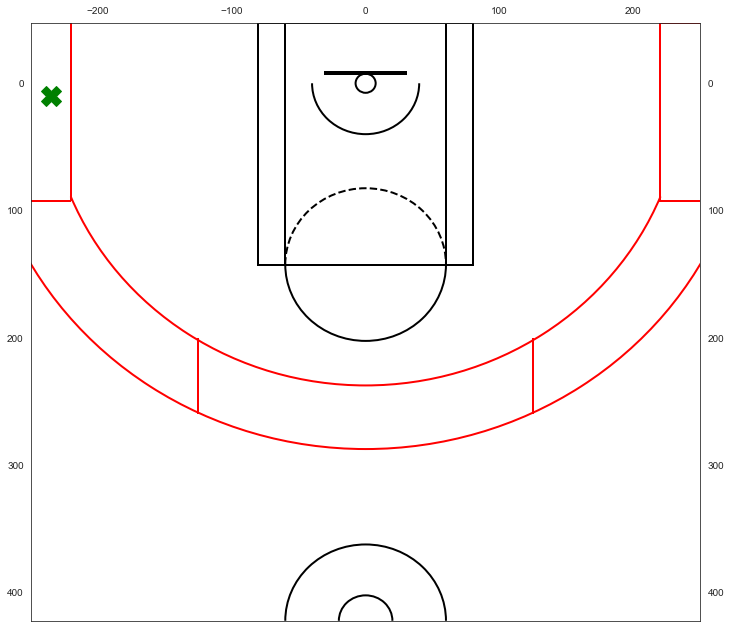

In [21]:
visualize_shot(-235, 10)